In [1]:
import yaml
import torch
import numpy as np
import imageio.v3 as iio
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [3]:
encoder, predictor = torch.hub.load('facebookresearch/vjepa2', 'vjepa2_vit_large')
encoder.cuda()

VisionTransformer(
  (patch_embed): PatchEmbed3D(
    (proj): Conv3d(3, 1024, kernel_size=(2, 16, 16), stride=(2, 16, 16))
  )
  (blocks): ModuleList(
    (0-23): 24 x Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): RoPEAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
)

Test on two videos, the `/assets/surf.mp4` and `/assets/koala.mp4`, to see what this latent space of the encoder's latent space looks like when down projecting it to 3 channels. 

The frame size for reading (720, 1280) is different from the source frame size (1280, 720).


Number of total frames: 596


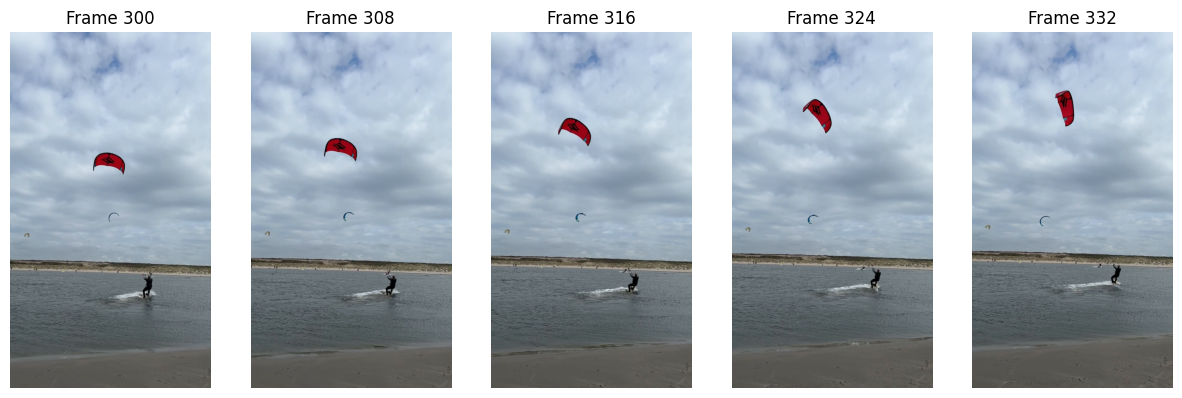

In [4]:
frames = iio.imread('assets/surf.mp4', plugin="FFMPEG")
print("Number of total frames:", len(frames))

n_frames = 5
fig, axes = plt.subplots(1, 5, figsize=(3 * n_frames, 6))
for i in range(n_frames):
    frame_i = 300 + i * 8
    axes[i].imshow(frames[frame_i])
    axes[i].set_title(f"Frame {frame_i}")
    axes[i].axis('off')

plt.show()

In [5]:
# Create a subset of the clips as input, I take larger jumps between frames to see more change
# in the PCA visualizations.

# Take the parts where the surfer gets up, and preprocess in the right format.
x_clip = torch.tensor(frames[220:346:4]).moveaxis(-1, 0)
x_clip = x_clip.unsqueeze(0).float().cuda()

x_clip.shape

torch.Size([1, 3, 32, 1280, 720])

In [7]:
# Obtain the latent encodings
with torch.no_grad(): 
    z = encoder(x_clip)

embed_dim = encoder.embed_dim
patch_h = x_clip.shape[3] // encoder.patch_size
patch_w = x_clip.shape[4] // encoder.patch_size
patch_t = z.shape[1] // (patch_h * patch_w) # The final timesteps in the output

# Preparing everything for PCA
z = z.reshape(-1, embed_dim)
z.shape

torch.Size([57600, 1024])

Initially I started using the sklearn PCA and minMax scaler however running this on CPU was not always reliable and sometimes crashed.

```python
pca_input_features = z.detach().cpu().numpy().reshape(-1, embed_dim)
pca = PCA(n_components=3)
scaler = MinMaxScaler(clip=True)

# PCA
pca.fit(pca_input_features)

# MinMax Scaling [0, 1]
scaler.fit(pca_features_all)

pca_features_all = pca.transform(pca_input_features)
pca_features_all = scaler.transform(pca_features_all) 
```

In [8]:
def pca(X, n_components=3):
    Z_mean = X.mean(0, keepdim=True)
    Z = X - Z_mean
    U, S, VT = torch.linalg.svd(Z, full_matrices=False)
    
    max_col = torch.argmax(torch.abs(U), dim=0)
    signs = torch.sign(U[max_col, range(U.shape[1])])
    VT *= signs[:, None]

    Z = torch.matmul(Z, VT[:n_components].T)
    return Z

def min_max(X, target_min = 0.0, target_max = 1.0):
    eps = 1e-8
    X_std = (X - X.min(0, True).values) / (X.max(0, True).values - X.min(0, True).values + eps)
    X_scaled = X_std * (target_max - target_min) + target_min
    return X_scaled

z_pca = min_max(pca(z))
z_pca.shape

torch.Size([57600, 3])

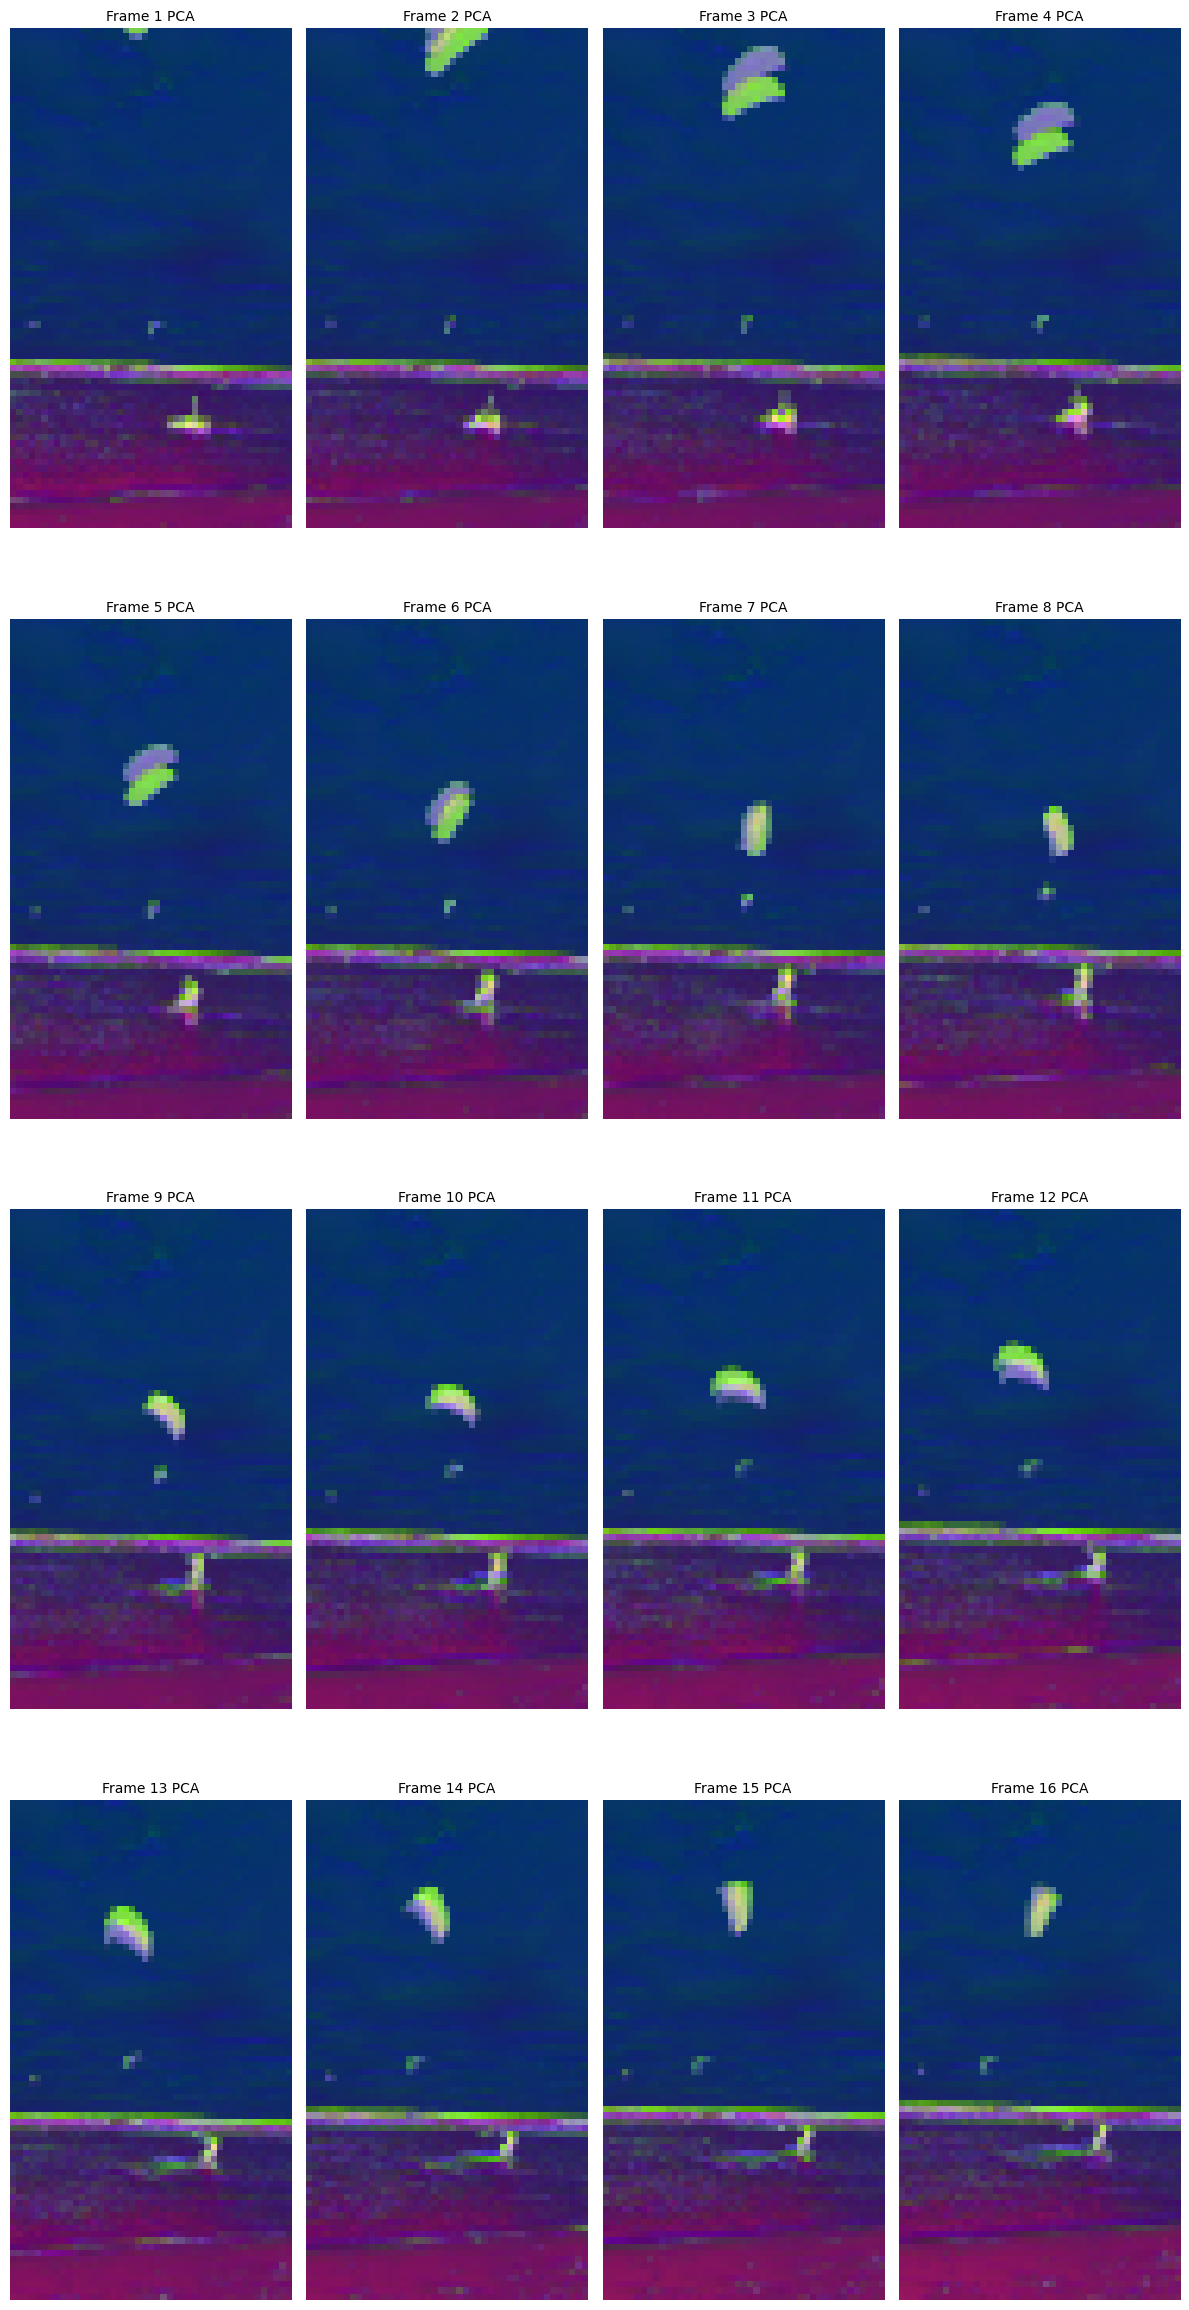

In [9]:
# Matplot sizes
cols = int(np.ceil(np.sqrt(patch_t)))
rows = int(np.ceil(patch_t / cols))
fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 6 * rows))
axes_flat = axes.flatten()

# Visualize each output frame 1 by 1, the patchEmbed3D compresses 2 frames
# to be 1 frame.
tokens_in_frame = patch_h * patch_w
for i in range(patch_t):
    features_frame = z_pca[i * tokens_in_frame:(i+1)*tokens_in_frame].cpu().numpy()
    rgb_frame = features_frame.reshape(patch_h, patch_w, 3)
    
    axes_flat[i].imshow(rgb_frame)
    axes_flat[i].set_title(f"Frame {i+1} PCA", fontsize=10)
    axes_flat[i].axis("off")

plt.tight_layout()
plt.show()

This video nicely displays that it keeps track of the object moving in the frame. Now for the koala video.

Number of total frames: 985


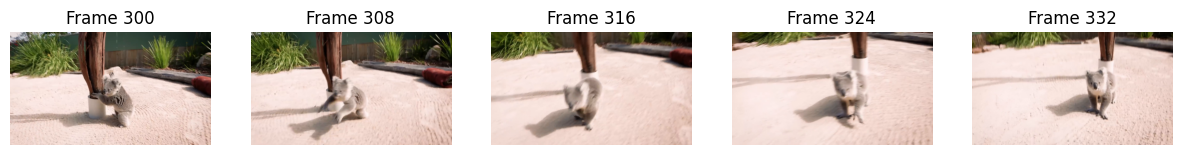

In [10]:
frames = iio.imread('assets/koala.mp4', plugin="FFMPEG")
print("Number of total frames:", len(frames))

n_frames = 5
fig, axes = plt.subplots(1, 5, figsize=(3 * n_frames, 6))
for i in range(n_frames):
    frame_i = 300 + i * 8
    axes[i].imshow(frames[frame_i])
    axes[i].set_title(f"Frame {frame_i}")
    axes[i].axis('off')

plt.show()

In [11]:
# Use the same range for the frames
x_clip = torch.tensor(frames[200:300:4]).moveaxis(-1, 0)
x_clip = x_clip.unsqueeze(0).float().cuda()

with torch.no_grad(): 
    z = encoder(x_clip)

# Here the height and width are swapped.
patch_h = x_clip.shape[3] // encoder.patch_size
patch_w = x_clip.shape[4] // encoder.patch_size
patch_t = z.shape[1] // (patch_h * patch_w) # The final timesteps in the output

# Preparing everything for PCA
z = z.detach().reshape(-1, embed_dim)
z.shape

torch.Size([43200, 1024])

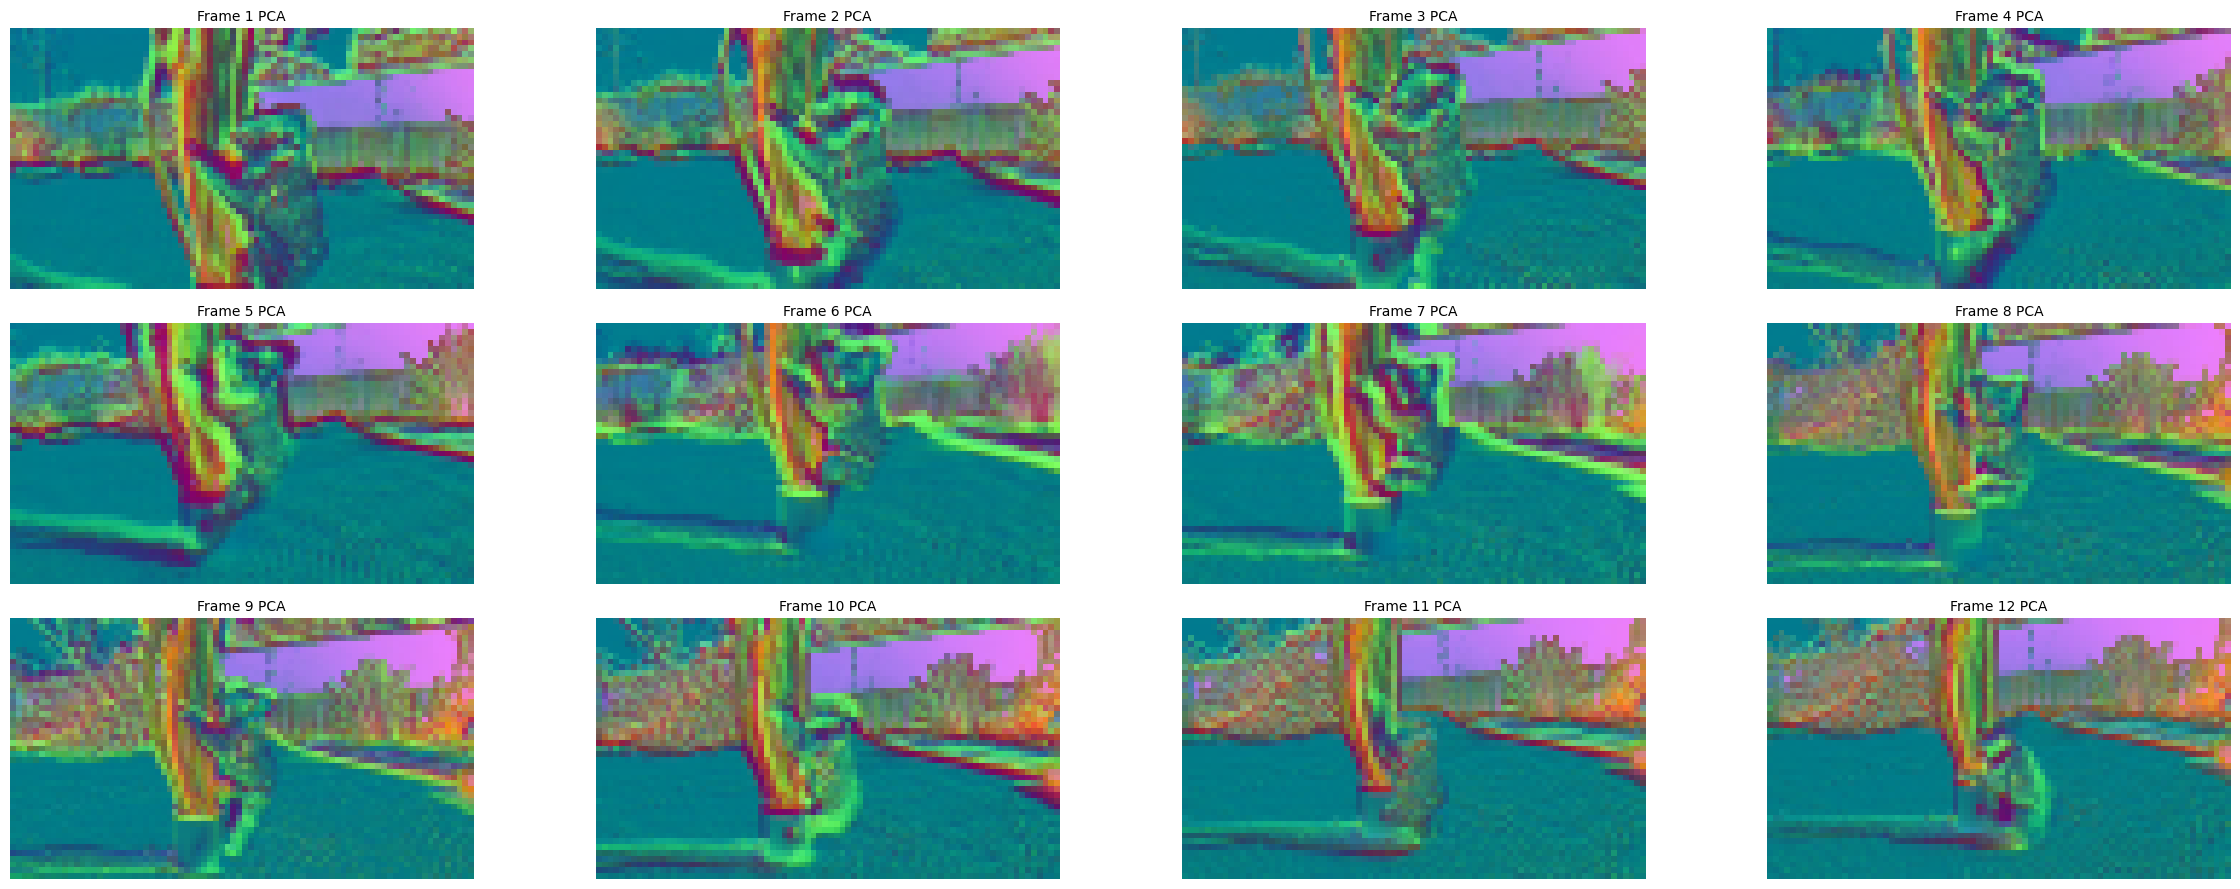

In [12]:
z_pca = min_max(pca(z))

# Matplot sizes
cols = int(np.ceil(np.sqrt(patch_t)))
rows = int(np.ceil(patch_t / cols))
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 3 * rows))
axes_flat = axes.flatten()

# Visualize each output frame 1 by 1, the patchEmbed3D compresses 2 frames
# to be 1 frame.
tokens_in_frame = patch_h * patch_w
for i in range(patch_t):
    features_frame = z_pca[i * tokens_in_frame:(i+1)*tokens_in_frame].cpu().numpy()
    rgb_frame = features_frame.reshape(patch_h, patch_w, 3)
    
    axes_flat[i].imshow(rgb_frame)
    axes_flat[i].set_title(f"Frame {i+1} PCA", fontsize=10)
    axes_flat[i].axis("off")

plt.tight_layout()
plt.show()

As the key feature of the JEPA models are predicting tokens in latent space and not in pixel space as a maskedAutoencoder (MAE) model would, we can not reconstruct the masked patches as you would in MAE. For this in the original V-JEPA1 model they introduced a diffusion model to reinterpret the latent space and fill in the missing masks. Instead here I want to try to make the model predict the latent space tokens and compare them to the unmasked inputs.

In [13]:
predictor.cuda() # Now also put the predictor model on the CUDA VRAM

VisionTransformerPredictor(
  (predictor_embed): Linear(in_features=1024, out_features=384, bias=True)
  (mask_tokens): ParameterList(
      (0): Parameter containing: [torch.float32 of size 1x1x384 (cuda:0)]
      (1): Parameter containing: [torch.float32 of size 1x1x384 (cuda:0)]
      (2): Parameter containing: [torch.float32 of size 1x1x384 (cuda:0)]
      (3): Parameter containing: [torch.float32 of size 1x1x384 (cuda:0)]
      (4): Parameter containing: [torch.float32 of size 1x1x384 (cuda:0)]
      (5): Parameter containing: [torch.float32 of size 1x1x384 (cuda:0)]
      (6): Parameter containing: [torch.float32 of size 1x1x384 (cuda:0)]
      (7): Parameter containing: [torch.float32 of size 1x1x384 (cuda:0)]
      (8): Parameter containing: [torch.float32 of size 1x1x384 (cuda:0)]
      (9): Parameter containing: [torch.float32 of size 1x1x384 (cuda:0)]
  )
  (predictor_blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=

In [24]:
# Clip from the koala video
x_clip = torch.tensor(frames[286:300:4]).moveaxis(-1, 0)
x_clip = x_clip.unsqueeze(0).float().cuda()
x_clip.shape

torch.Size([1, 3, 4, 720, 1280])

In [25]:
batch_size = 1
patch_h = x_clip.shape[3] // encoder.patch_size
patch_w = x_clip.shape[4] // encoder.patch_size
patch_t = x_clip.shape[2] // 2

total_patches = patch_h * patch_w
num_mask_patches = total_patches // 6  # 1/6 masked block
num_vis_patches = total_patches - num_mask_patches

block_h = int(num_mask_patches ** 0.5)
block_w = int(num_mask_patches ** 0.5)

# Choose center position
start_h = (patch_h - block_h) // 2
start_w = (patch_w - block_w) // 2

mask_2d = torch.ones((patch_h, patch_w), dtype=torch.bool)
mask_2d[start_h:start_h + block_h, start_w:start_w + block_w] = False
mask_3d = mask_2d.flatten().repeat(patch_t)

# Indices
all_indices = torch.arange(patch_t * total_patches)
visible_indices = torch.nonzero(mask_3d, as_tuple=False).flatten()
masked_indices = torch.nonzero(~mask_3d, as_tuple=False).flatten()

mask_tensor_enc = visible_indices.view(batch_size, -1).long()
mask_tensor_pred = masked_indices.view(batch_size, -1).long()

masks_enc = [mask_tensor_enc.to(x_clip.device)]
masks_pred = [mask_tensor_pred.to(x_clip.device)]

with torch.no_grad():
    z_enc = encoder(x_clip, masks_enc)
    z_pred = predictor(z_enc, masks_pred, masks_enc)
    
z_reconstruct = torch.zeros(
    z_pred.shape[0],
    patch_t * total_patches, 
    z_pred.shape[-1], 
    dtype=z_pred.dtype, 
    device=z_pred.device
)

z_reconstruct[:, mask_tensor_enc[0], :] = z_enc
z_reconstruct[:, mask_tensor_pred[0], :] = z_pred

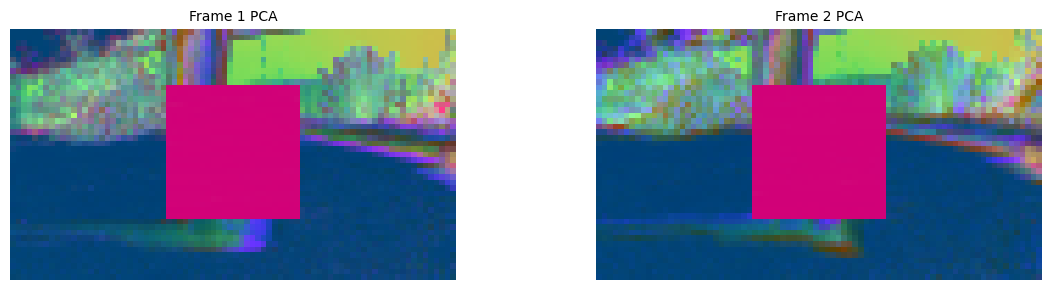

In [26]:
z_pca = min_max(pca(z_reconstruct.reshape(-1, embed_dim)))

cols = int(np.ceil(np.sqrt(patch_t)))
rows = int(np.ceil(patch_t / cols))
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 3 * rows))
axes_flat = axes.flatten()

# Visualize each output frame 1 by 1, the patchEmbed3D compresses 2 frames to be 1 frame.
tokens_in_frame = patch_h * patch_w
for i in range(patch_t):
    features_frame = z_pca[i * tokens_in_frame:(i+1)*tokens_in_frame].cpu().numpy()
    rgb_frame = features_frame.reshape(patch_h, patch_w, 3)
    
    axes_flat[i].imshow(rgb_frame)
    axes_flat[i].set_title(f"Frame {i+1} PCA", fontsize=10)
    axes_flat[i].axis("off")

plt.tight_layout()
plt.show()

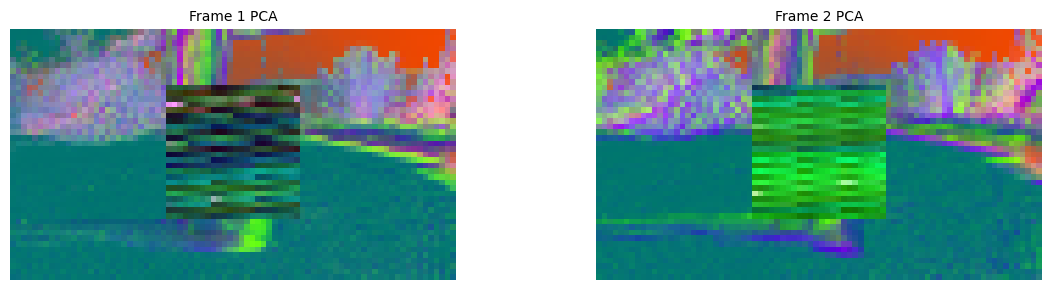

In [27]:
z_reconstruct = torch.zeros(
    z_pred.shape[0],
    patch_t * total_patches, 
    3, 
    dtype=z_pred.dtype, 
    device=z_pred.device
)

# Reconstruct both patches indepently as the ranges of the outputs for different
# networks dont match
z_reconstruct[0, mask_tensor_enc[0], :] = min_max(pca(z_enc.reshape(-1, embed_dim)))
z_reconstruct[0, mask_tensor_pred[0], :] = min_max(pca(z_pred.reshape(-1, embed_dim)))
z_reconstruct = z_reconstruct.reshape(patch_t*total_patches, 3)

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 3 * rows))
axes_flat = axes.flatten()

tokens_in_frame = patch_h * patch_w
for i in range(patch_t):
    features_frame = z_reconstruct[i * tokens_in_frame:(i+1)*tokens_in_frame].cpu().numpy()
    rgb_frame = features_frame.reshape(patch_h, patch_w, 3)
    
    axes_flat[i].imshow(rgb_frame)
    axes_flat[i].set_title(f"Frame {i+1} PCA", fontsize=10)
    axes_flat[i].axis("off")

plt.tight_layout()
plt.show()

Need to check if the PCA output should not necessarily match, or if I am passing the wrong mask tokens to the predictor network to give a good output.